# Setup

In [4]:
!pip3 install bitsandbytes transformers accelerate peft Pillow torch torchvision torchaudio tensorflow tensorrt ipywidgets -q
!pip3 install --upgrade notebook jupyter -q



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 KB 24.1 MB/s eta 0:00:00


In [5]:
!pip3 install git+https://github.com/huggingface/diffusers.git -q
# !pip3 install git+https://github.com/huggingface/diffusers.git@5f150c4cef2140342c66ef44ba8f36b5844a51b1




In [6]:
import sys
print(sys.executable)


/home/emma/code/emotiscope/moody-env/bin/python3


In [7]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "CPU"
print(device)


import tensorflow as tf

# Check if a GPU is available and TensorRT is integrated
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Attempt to create a simple TensorRT graph
        tf.config.experimental.set_memory_growth(gpus[0], True)
        from tensorflow.python.compiler.tensorrt import trt_convert as trt
        print("TensorRT is available!")
    except ImportError as e:
        print("TensorRT integration not available:", e)
else:
    print("GPU not available.")



2024-05-26 22:57:40.344420: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 22:57:40.382328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 22:57:41.045102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


cuda
TensorRT is available!


In [8]:
!nvidia-smi


Sun May 26 22:57:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:1A:00.0 Off |                  N/A |
|  0%   21C    P8              16W / 350W |    579MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py



--2024-05-26 22:58:01--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84311 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py.3’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.003s  

2024-05-26 22:58:01 (23.5 MB/s) - ‘train_dreambooth_lora_sdxl.py.3’ saved [84311/84311]



In [12]:
import logging

# Set up basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Constants

In [13]:
INPUT_FOLDER = "./faces/"
EXT = ".png"
INPUT_FILES =  f"{INPUT_FOLDER}*{EXT}"
CAPTION_PREFIX ="a TOK emoticon"

# Load Photos

In [38]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

./faces/*.png


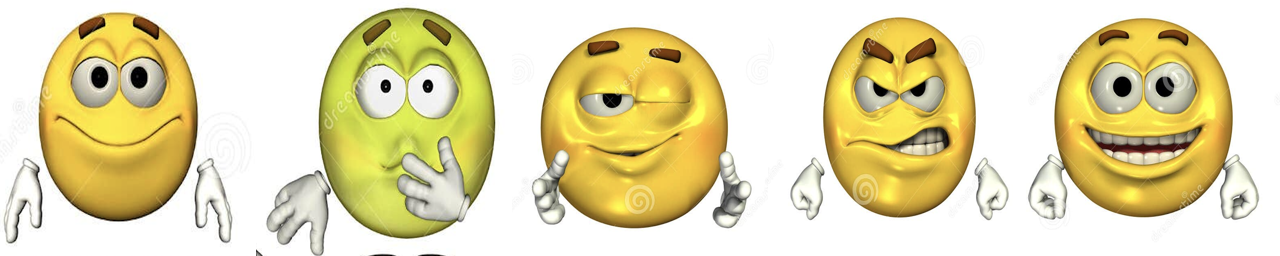

In [39]:
import glob

# change path to display images from your local dir
img_paths = INPUT_FILES
print(img_paths)
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [16]:
# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [17]:
import glob
from PIL import Image

imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(INPUT_FILES)]

In [18]:
import json
from multiprocessing import Pool

def process_image(img_and_path):
    img, path = img_and_path
    logging.info(f"Processing image: {img}")
    
    try:
        caption = CAPTION_PREFIX + caption_images(path).split("\n")[0]
        result = {
            "file_name": img.split("/")[-1],  # Assumes `img` is a path
            "prompt": caption
        }
        logging.info(f"Finished processing image: {img}")
        return result
    except Exception as e:
        logging.error(f"Error processing image {img}: {str(e)}")
        return None


logging.info("Starting the multiprocessing task")
    
with open(f'{INPUT_FOLDER}metadata.jsonl', 'w') as outfile:
    for entry in imgs_and_paths:
        if entry is not None:
            result = process_image(entry)
            json.dump(result, outfile)
            outfile.write('\n')

logging.info("Completed the multiprocessing task")


2024-05-26 22:58:11,126 - INFO - Starting the multiprocessing task
2024-05-26 22:58:11,128 - INFO - Processing image: ./faces/faces25.png
2024-05-26 22:58:11,823 - INFO - Finished processing image: ./faces/faces25.png
2024-05-26 22:58:11,824 - INFO - Processing image: ./faces/faces2.png
2024-05-26 22:58:11,922 - INFO - Finished processing image: ./faces/faces2.png
2024-05-26 22:58:11,923 - INFO - Processing image: ./faces/faces12.png
2024-05-26 22:58:12,036 - INFO - Finished processing image: ./faces/faces12.png
2024-05-26 22:58:12,037 - INFO - Processing image: ./faces/faces4.png
2024-05-26 22:58:12,356 - INFO - Finished processing image: ./faces/faces4.png
2024-05-26 22:58:12,357 - INFO - Processing image: ./faces/faces7.png
2024-05-26 22:58:12,489 - INFO - Finished processing image: ./faces/faces7.png
2024-05-26 22:58:12,490 - INFO - Processing image: ./faces/faces9.png
2024-05-26 22:58:12,799 - INFO - Finished processing image: ./faces/faces9.png
2024-05-26 22:58:12,800 - INFO - Pr

# Free Memory

In [19]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

# Prep for Training

In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /home/emma/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [21]:
from huggingface_hub import notebook_login
notebook_login()

In [22]:
!pip3 install datasets 

In [23]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="faces" \
  --output_dir="face_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a TOK emoticon" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2024-05-26 22:58:25.756097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 22:58:25.756095: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 22:58:25.793146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 22:58:25.793146: I tensorflow/core/platform/cpu_feature_guard.cc:210]

In [30]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "face_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [31]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="'a TOK emoticon'",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
    use_dora=False
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

events.out.tfevents.1715324064.imagination.6639.1:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

events.out.tfevents.1715323988.imagination.5981.1:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

events.out.tfevents.1716785177.imagination.106673.1:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

events.out.tfevents.1716789519.imagination.108834.1:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

events.out.tfevents.1715323988.imagination.5981.0:   0%|          | 0.00/326 [00:00<?, ?B/s]

events.out.tfevents.1715324064.imagination.6639.0:   0%|          | 0.00/92.5k [00:00<?, ?B/s]

events.out.tfevents.1716785177.imagination.106673.0:   0%|          | 0.00/117k [00:00<?, ?B/s]

events.out.tfevents.1716789519.imagination.108834.0:   0%|          | 0.00/117k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nworb-ucsb/face_LoRA/commit/435a4304ea140e8ca73b5aa77c19385f83f03d34', commit_message='End of training', commit_description='', oid='435a4304ea140e8ca73b5aa77c19385f83f03d34', pr_url=None, pr_revision=None, pr_num=None)

In [32]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/nworb-ucsb/face_LoRA

# Inference

In [33]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

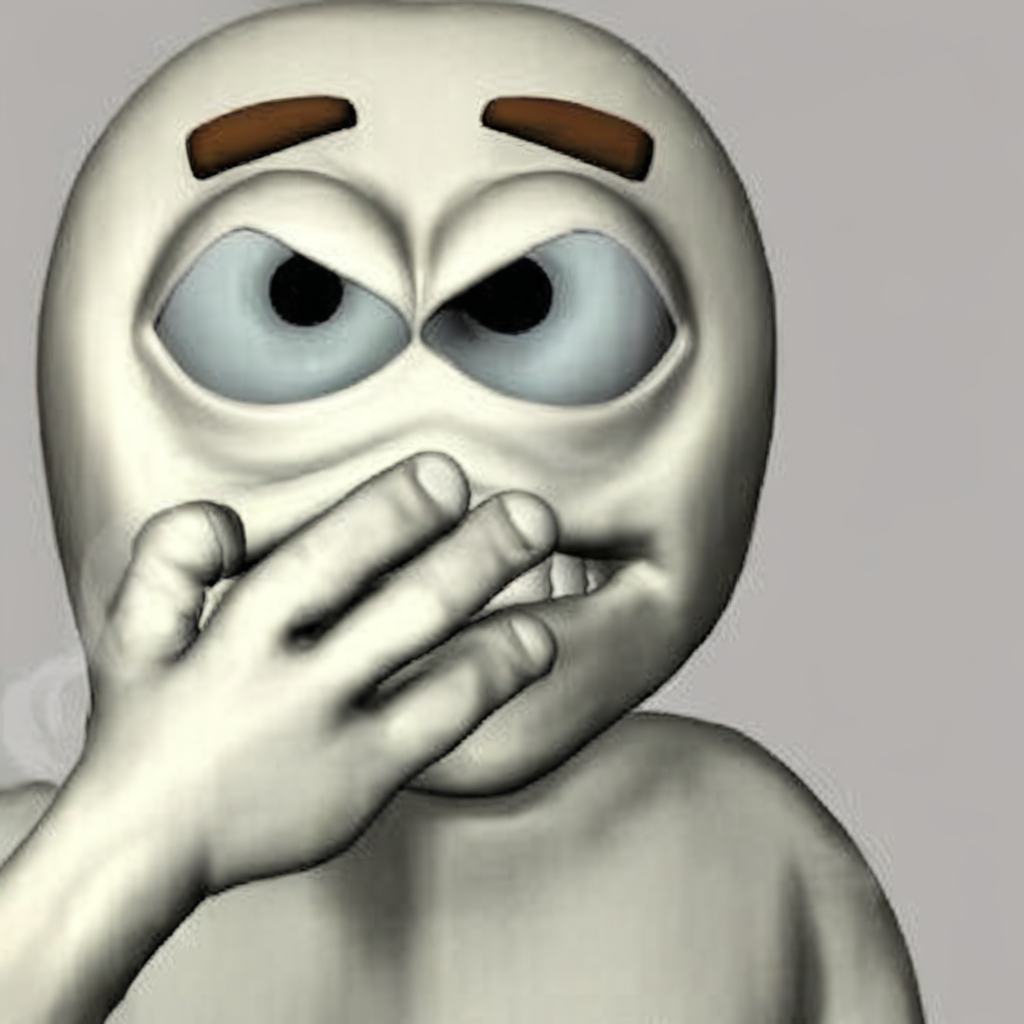

In [37]:
prompt = "a photo of a TOK emoticon who is covering his mouth" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image